In [1]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                               f1_score, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
import anndata
from tqdm import tqdm
import wandb



# Training function for the autoencoder
def train_autoencoder(train_loader, val_loader, input_dim, latent_dim=32, num_epochs=100, 
                      learning_rate=5e-4, weight_decay=1e-4, patience=10, save_path='models'):
    """
    Train the autoencoder model
    
    Parameters:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - input_dim: Input dimension (number of TFs)
    - latent_dim: Dimension of latent space
    - num_epochs: Maximum number of training epochs
    - learning_rate: Learning rate for optimizer
    - weight_decay: L2 regularization strength
    - patience: Early stopping patience
    - save_path: Directory to save model and plots
    
    Returns:
    - model: Trained autoencoder model
    - train_losses: List of training losses per epoch
    - val_losses: List of validation losses per epoch
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Initialize model
    model = Autoencoder(input_dim, latent_dim)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    model.to(device)
    

    # Initialize WandB
    # wandb.init(project="car-t-IP-MIL", name="autoencoder-training")
    
    # Training setup
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # wandb.log({"train_loss": train_loss})
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                outputs = model(data)
                loss = criterion(outputs, data)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        # wandb.log({"val_loss": val_loss})
        
        # Learning rate adjustment
        scheduler.step() #val_loss)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save best model
            torch.save(model.state_dict(), f'{save_path}/best_autoencoder_simplified.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    # Load best model
    model.load_state_dict(torch.load(f'{save_path}/best_autoencoder_simplified.pth'))
    
    # Plot training and validation loss
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(val_losses, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Autoencoder Training and Validation Loss')
    # plt.legend()
    # plt.savefig(f'{save_path}/autoencoder_training_loss.png')
    
    return model, train_losses, val_losses

# 5. Evaluation function
def evaluate_autoencoder(model, test_loader, adata, tf_names, save_path='results'):
    """
    Evaluate the trained autoencoder
    
    Parameters:
    - model: Trained autoencoder model
    - test_loader: DataLoader for test data
    - adata: Original AnnData object
    - tf_names: Names of transcription factors
    - save_path: Directory to save evaluation results
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Test set evaluation
    model.eval()
    test_loss = 0
    criterion = nn.MSELoss()
    
    all_inputs = []
    all_reconstructions = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            test_loss += loss.item()
            
            # Collect inputs and reconstructions for later analysis
            all_inputs.append(data.cpu().numpy())
            all_reconstructions.append(outputs.cpu().numpy())
    
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.6f}')
    # wandb.log({"test_loss": test_loss})
    
    # Combine batches
    all_inputs = np.vstack(all_inputs)
    all_reconstructions = np.vstack(all_reconstructions)
    
    # Calculate reconstruction error for each TF
    mse_per_tf = np.mean((all_inputs - all_reconstructions)**2, axis=0)
    
    # Plot reconstruction error per TF
    # plt.figure(figsize=(14, 6))
    # plt.bar(range(len(mse_per_tf)), mse_per_tf)
    # plt.xticks(range(len(mse_per_tf)), tf_names, rotation=90)
    # plt.xlabel('Transcription Factors')
    # plt.ylabel('MSE')
    # plt.title('Reconstruction Error per Transcription Factor')
    # plt.tight_layout()
    # plt.savefig(f'{save_path}/tf_reconstruction_error.png')
    
    # Generate latent space representation for all cells
    all_cells = adata.X
    if isinstance(all_cells, np.ndarray) == False:
        all_cells = all_cells.toarray()
    
    all_cells_tensor = torch.FloatTensor(all_cells).to(device)
    
    with torch.no_grad():
        latent_vectors = model.encode(all_cells_tensor).cpu().numpy()
    
    # Create a new AnnData object with latent representations
    adata_latent = sc.AnnData(latent_vectors)
    adata_latent.obs = adata.obs.copy()  # Copy cell annotations
    
    # UMAP visualization of latent space
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # os.makedirs('figures/umapresults', exist_ok=True)
    # if 'patient_id' in adata_latent.obs.columns:
    #     sc.pl.umap(adata_latent, color=['patient_id'], save=f'{save_path}/latent_umap_by_patient.png')
    
    # if 'Response_3m' in adata_latent.obs.columns:
    #     sc.pl.umap(adata_latent, color=['Response_3m'], save=f'{save_path}/latent_umap_by_response.png')

    
    if 'patient_id' in adata_latent.obs.columns:
        fig = sc.pl.umap(adata_latent, color=['patient_id'], show=False, return_fig=True)
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(f'{save_path}/latent_umap_by_patient.png', bbox_inches='tight')
        plt.close(fig)
    
    if 'Response_3m' in adata_latent.obs.columns:
        fig = sc.pl.umap(adata_latent, color=['Response_3m'], show=False, return_fig=True)
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(f'{save_path}/latent_umap_by_response.png', bbox_inches='tight')
        plt.close(fig)
    
    
    # Save latent representation for MIL
    adata_latent.write(f'{save_path}/latent_representation.h5ad')
    
    return adata_latent, test_loss

# 6. Main execution function
def main(file_path, latent_dim=48, num_epochs=100):
    """
    Main function to run the entire pipeline
    
    Parameters:
    - file_path: Path to h5ad file with SCENIC results
    - latent_dim: Dimension of latent space
    - num_epochs: Number of training epochs
    """
    # Load and explore data
    adata = load_and_explore_data(file_path)
    
    # Extract TF names
    tf_names = adata.var_names.tolist()
    
    # Preprocess data
    train_loader, val_loader, test_loader, input_dim = preprocess_data(adata)
    
    # Train autoencoder
    model, train_losses, val_losses = train_autoencoder(
        train_loader, val_loader, input_dim, latent_dim, num_epochs
    )
    
    # Evaluate autoencoder
    adata_latent, test_loss = evaluate_autoencoder(model, test_loader, adata, tf_names)
    
    print("Autoencoder training and evaluation complete!")
    print(f"Final test loss: {test_loss:.6f}")
    print(f"Latent representation shape: {adata_latent.shape}")
    print("Latent representation saved for MIL implementation.")
    
    return model, adata_latent


    


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight

# 1. MIL Dataset class for patient bags
class PatientBagDataset(Dataset):
    """
    Dataset for Multiple Instance Learning where each bag contains cells from one patient
    """
    def __init__(self, adata, patient_col='patient_id', label_col='Response_3m'):
        """
        Initialize the MIL dataset
        
        Parameters:
        - adata: AnnData object with latent representations and patient information
        - patient_col: Column name for patient identifiers
        - label_col: Column name for patient response labels
        """
        self.adata = adata
        self.patient_col = patient_col
        self.label_col = label_col
        
        # Get unique patients
        self.patients = adata.obs[patient_col].unique()
        
        # Create a mapping of patient to label
        self.patient_to_label = dict(zip(
            adata.obs[patient_col], 
            adata.obs[label_col]
        ))

        #############################################
        

        if "Sample_source" in adata.obs.columns:
            # Create one-hot encoding for Sample_source using unique values
            sample_sources = list(adata.obs["Sample_source"].unique())
            self.patient_metadata = {}
            
            # Get Sample_source for each patient
            patient_source_map = adata.obs.groupby(self.patient_col, observed=True)['Sample_source'].first().to_dict()
            
            # Create one-hot encoding for each patient
            for patient in self.patients:
                if patient in patient_source_map:
                    source = patient_source_map[patient]
                    one_hot = [1 if s == source else 0 for s in sample_sources]
                    self.patient_metadata[patient] = one_hot
            


        ##############################################
        
        # Create patient bags
        self.patient_bags = {}
        self.patient_labels = {}
        
        for patient in self.patients:
            # Get indices for this patient
            indices = np.where(adata.obs[patient_col] == patient)[0]
            
            # Get features for this patient's cells
            patient_data = adata.X[indices]
            if isinstance(patient_data, np.ndarray) == False:
                patient_data = patient_data.toarray()
                
            self.patient_bags[patient] = patient_data
            
            # Get label for this patient
            # Assuming all cells from the same patient have the same label
            label = self.patient_to_label[patient]
            self.patient_labels[patient] = label
        
        # Convert patients to a list for indexing
        self.patient_list = list(self.patients)
    
    def __len__(self):
        """Return the number of bags (patients)"""
        return len(self.patient_list)
    
    def __getitem__(self, idx):
        """
        Get a patient bag
        
        Returns:
        - bag: Tensor of shape [num_instances, features] for the patient
        - label: Label for the patient
        - patient: Patient identifier
        """
        patient = self.patient_list[idx]
        bag = self.patient_bags[patient]
        label = self.patient_labels[patient]
        
        # Convert to proper format
        bag = torch.FloatTensor(bag)
        
        # Handle different label types
        if isinstance(label, str):
            # Map string labels to integers
            
            label_map = {"NR":0, "OR":1}
            label = label_map[label]
        
        label = torch.tensor(label, dtype=torch.long)

        if self.patient_metadata:
            one_hot_sample_source = torch.tensor(self.patient_metadata[patient], dtype=torch.float)
            return bag, label, patient, one_hot_sample_source
        else:
            return bag, label, patient

# 2. Attention-based MIL model
class AttentionMIL(nn.Module):
    """
    Attention-based Multiple Instance Learning model as used in scMILD
    """
    def __init__(self, input_dim, num_classes=2, hidden_dim=128, dropout=0.25, sample_source_dim=None):
        """
        Initialize the MIL model
        
        Parameters:
        - input_dim: Dimension of the input features (output of autoencoder)
        - num_classes: Number of response classes
        - hidden_dim: Dimension of hidden layer
        - dropout: Dropout rate
        """
        super(AttentionMIL, self).__init__()

        self.use_sample_source = sample_source_dim is not None
        
        # Feature extractor network
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            # nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        if self.use_sample_source:
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim + sample_source_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
        else:
            # Classifier
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            ) #nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, sample_source=None, return_attention=False):
        """
        Forward pass
        
        Parameters:
        - x: Input bag of instances [batch_size, num_instances, features]
        - return_attention: Whether to return attention weights
        - sample_source: One-hot encoded
        
        Returns:
        - logits: Class logits [batch_size, num_classes]
        - attention_weights: Attention weights if return_attention=True
        """
        device = next(self.parameters()).device
        # x shape: [batch_size, num_instances, features]
        batch_size = len(x)
        
        # Process each bag
        all_logits = []
        all_attention_weights = []
        
        for i in range(batch_size):
            instances = x[i]  # [num_instances, features]
            
            # Extract features from each instance
            instance_features = self.feature_extractor(instances)  # [num_instances, hidden_dim]
            
            # Calculate attention scores
            attention_scores = self.attention(instance_features)  # [num_instances, 1]
            attention_weights = F.softmax(attention_scores, dim=0)  # [num_instances, 1]
            
            # Calculate weighted average of instance features
            weighted_features = torch.sum(
                instance_features * attention_weights, dim=0
            )  # [hidden_dim]
            
            

            #########################################################
            ########## Add sample source if provided #################
            #########################################################
            if self.use_sample_source and sample_source is not None:
                # Print shape and example values for debugging
                print(f"Sample source shape: {sample_source.shape}")
                print(f"Example sample source value: {sample_source[0]}")
            # get the sample source for this patient
                sample_source_i = sample_source[i]

                # Verify sample_source_i has the expected dimension
                if len(sample_source_i) != 4:
                    print(f"Warning: sample_source dimension mismatch. Expected {4}, got {len(sample_source_i)}")
                
                # weighted_features shape: [hidden_dim] (e.g. [128])
                # sample_source_i shape: [4] 
                # Need to unsqueeze to match dimensions
                weighted_features = weighted_features.unsqueeze(0)  # Shape: [1, hidden_dim]
                sample_source_i = sample_source_i.unsqueeze(0)     # Shape: [1, 4]
                # Concatenate along dim=1 since we're joining features
                combined_features = torch.cat([weighted_features, sample_source_i], dim=1)  # Shape: [1, hidden_dim + 4]
                combined_features = combined_features.squeeze(0)    # Back to [hidden_dim + 4] for classifier
                logits = self.classifier(combined_features)
            
            else:
                logits = self.classifier(weighted_features)
        # Stack results
        logits = torch.stack(all_logits)  # [batch_size, num_classes]
        attention_weights = all_attention_weights  # List of [num_instances, 1]
        
        if return_attention:
            return logits, attention_weights
        else:
            return logits




# define a leave one out cross validation function
def leave_one_out_cross_validation(adata, input_dim, num_classes=2, hidden_dim=128, sample_source_dim=4,
                                  num_epochs=50, learning_rate=5e-4, weight_decay = 1e-2, 
                                  save_path='results'):
    """
    Perform leave-one-out cross-validation for the MIL model
    # Parameters:
    - adata: AnnData object with latent representations
    - input_dim: Input dimension (latent space dimension)
    - num_classes: Number of response classes
    - hidden_dim: Dimension of hidden layer
    - num_epochs: Maximum number of training epochs
    - learning_rate: Learning rate for optimizer
    - weight_decay: L2 regularization strength

    Returns:
    - cv_results: Dictionary of cross-validation results
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    os.makedirs(save_path, exist_ok=True)

    # initiate wandb
    # wandb.init(project="car-t-IP-MIL", name="loocv-mil",
    #            config={
    #                "input_dim": input_dim,
    #                "num_classes": num_classes,
    #                "hidden_dim": hidden_dim,
    #                "num_epochs": num_epochs,
    #                "learning_rate": learning_rate,
    #                "weight_decay": weight_decay,
    #                "save_path": save_path
    #            })
    
    # create dataset
    full_dataset = PatientBagDataset(adata)

    # get all patients and their labels
    patients = np.array(full_dataset.patient_list)
    labels = np.array([full_dataset.patient_labels[p] for p in patients])

    print(f"Performing leave-one-out cross-validation for {len(patients)} patients...")

    cv_results = {
        'fold_metrics': [], # store per-fold metrics for reference
        'patient_predictions': {},
        'attention_weights': {}
    }

    # Initialize accumulators for all predictions across folds
    all_true_labels = []
    all_predicted_labels = []
    all_prediction_probs = []
    all_patient_ids = []

    # wandb_patient_table = wandb.Table(columns=["patient_id", "true_label", "predicted_label", "predicted_label", "correct"])

    # all_metrics = []
    # all_confusion_matrices = np.zeros((num_classes, num_classes))


    # LOOCV loop
    for i, test_patient in enumerate(patients):

        print(f"Fold {i+1}/{len(patients)} patients, testing on {test_patient}...")
        train_patients = np.array([p for p in patients if p != test_patient])
        

        # create train and test datasets
        train_dataset = PatientBagDataset(adata.copy()[adata.obs['patient_id'].isin(train_patients)])
        test_dataset = PatientBagDataset(adata.copy()[adata.obs['patient_id'] == test_patient])

        # create data loaders
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # create save path for this fold
        fold_save_path = os.path.join(save_path, f'patient_{test_patient}')
        os.makedirs(fold_save_path, exist_ok=True)

        # train model
        model = AttentionMIL(input_dim, num_classes, hidden_dim, sample_source_dim).to(device)

        # use weight classes to address class imbalance
        y = adata.obs.Response_3m.to_numpy()
        y = np.where(y == "NR", 0,1)
    
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
        class_weights = torch.FloatTensor(class_weights).to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    

        # criterion = torch.nn.CrossEntropyLoss()
        # optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

        
        # Training setup
        best_train_loss = float("inf")
        epochs_without_improvement = 0
        patience = 8

        history = {
            'train_loss': [],
            'train_acc': []
            
        }

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            for bags, batch_labels, _, one_hot_sample_source in train_loader:
                bags = [bag.to(device) for bag in bags]
                batch_labels = batch_labels.to(device)
                one_hot_sample_source = one_hot_sample_source.to(device)

                # Forward pass
                logits = model(bags, one_hot_sample_source)
                loss = criterion(logits, batch_labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update metrics
                train_loss += loss.item()
                _, preds = torch.max(logits.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (preds == batch_labels).sum().item()

            train_loss /= len(train_loader)
            train_acc = train_correct / train_total if train_total > 0 else 0

            # record history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)


            # use training loss for scheduler and early stopping since we have no validation set
            scheduler.step(train_loss)

            # print progress every 20 epochs
            if (epoch + 1) % 20 == 0:
                print(f'Patient {test_patient} - Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

            # log metrics
            # wandb.log({
            #     f"patient_{test_patient}/epoch": epoch + 1,
            #     f"patient_{test_patient}/train_loss": train_loss,
            #     f"patient_{test_patient}/train_acc": train_acc,
            #     f"patient_{test_patient}/learning_rate": optimizer.param_groups[0]['lr'],
            # })

            # early stopping
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                epochs_without_improvement = 0

                #save best model
                torch.save(model.state_dict(), os.path.join(fold_save_path, 'best_model.pth'))

            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f'Early stopping after {epoch+1} epochs')
                    break
        
        # load best model
        model.load_state_dict(torch.load(os.path.join(fold_save_path, 'best_model.pth')))

        # evaluate on test patient
        model.eval()
        device = next(model.parameters()).device

        # test_preds = []
        # test_labels = []
        # test_probs = []
        # patient_attentions = {}

        with torch.no_grad():
            for bags, batch_labels, patient_ids, one_hot_sample_source in test_loader:
                bags = [bag.to(device) for bag in bags]
                batch_labels = batch_labels.to(device)
                one_hot_sample_source = one_hot_sample_source.to(device)

                # Forward pass
                logits, attn_weights = model(bags, one_hot_sample_source, return_attention=True)

                # get predictions
                probs = F.softmax(logits, dim=1)
                _, preds = torch.max(logits, 1)

                # convert to numpy
                preds_np = preds.cpu().numpy()
                labels_np = batch_labels.cpu().numpy()
                probs_np = probs.cpu().numpy()

                # Get the patient_id and store results
                patient_id = patient_ids[0]
                true_label = labels_np[0]
                pred_label = preds_np[0]
                pos_prob = probs_np[0, 1] if num_classes == 2 else None

                # Add to accumulators for global metrics
                all_true_labels.append(true_label)
                all_predicted_labels.append(pred_label)
                all_prediction_probs.append(pos_prob if num_classes ==2 else probs_np[0])
                all_patient_ids.append(patient_id)

                # Store patient-specific results
                cv_results['patient_predictions'][patient_id] = {
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'probabilities': probs_np[0].tolist(),
                    'correct': (pred_label == true_label)
                }
                
                    
                

                # Store attention weights
                cv_results['attention_weights'][patient_id] = [w.cpu().numpy() for w in attn_weights]

                # Add to wandb table
                # wandb_patient_table.add_data(
                #     patient_id, 
                #     int(true_label), 
                #     int(pred_label), 
                #     float(pos_prob) if num_classes == 2 else 'N/A',
                #     bool(pred_label == true_label)
                # )

                
        # Calculate per-fold metrics for individual patient (for monitoring only)
        fold_correct = (preds_np[0] == labels_np[0])
        fold_metrics = {
            'patient_id': patient_id,
            'fold': i,
            'accuracy': 1.0 if fold_correct else 0.0,
            'true_label': int(labels_np[0]),
            'predicted_label': int(preds_np[0]),
            'prob_positive': float(probs_np[0, 1]) if num_classes == 2 else None
        }
        cv_results['fold_metrics'].append(fold_metrics)
        
        # Log patient result to wandb
        # wandb.log({
        #     f"patient_{patient_id}/true_label": labels_np[0],
        #     f"patient_{patient_id}/predicted_label": preds_np[0],
        #     f"patient_{patient_id}/prob_positive": probs_np[0, 1] if num_classes == 2 else None,
        #     f"patient_{patient_id}/correct": fold_correct
        # })

    # Convert accumulators to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)
    all_prediction_probs = np.array(all_prediction_probs)
    all_patient_ids = np.array(all_patient_ids)
    
    # Calculate overall metrics only once using ALL predictions
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    
    # For binary classification
    if num_classes == 2:
        overall_precision = precision_score(all_true_labels, all_predicted_labels)
        overall_recall = recall_score(all_true_labels, all_predicted_labels)
        overall_f1 = f1_score(all_true_labels, all_predicted_labels)
        overall_auc = roc_auc_score(all_true_labels, all_prediction_probs)
    else:
        # For multiclass classification
        overall_precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
        overall_recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
        overall_f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
        # For multiclass AUC, we'd need to calculate it differently (beyond scope here)
        overall_auc = 0.5  
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    
    # Calculate class-specific metrics
    class_metrics = {}
    for c in range(num_classes):
        true_positives = np.sum((all_true_labels == c) & (all_predicted_labels == c))
        actual_positives = np.sum(all_true_labels == c)
        predicted_positives = np.sum(all_predicted_labels == c)
        
        class_metrics[f'class_{c}'] = {
            'precision': true_positives / predicted_positives if predicted_positives > 0 else 0,
            'recall': true_positives / actual_positives if actual_positives > 0 else 0,
            'count': int(actual_positives)
        }
    
    # Store final metrics in results
    cv_results['overall_metrics'] = {
        'accuracy': float(overall_accuracy),
        'precision': float(overall_precision),
        'recall': float(overall_recall),
        'f1': float(overall_f1),
        'auc': float(overall_auc),
        'confusion_matrix': conf_matrix.tolist(),
        'class_metrics': class_metrics
    }
    
    # Log final results to wandb
    # wandb.log({
    #     "overall_accuracy": overall_accuracy,
    #     "overall_precision": overall_precision,
    #     "overall_recall": overall_recall,
    #     "overall_f1": overall_f1,
    #     "overall_auc": overall_auc,
    #     "patient_results": wandb_patient_table
    # })
    
    # Print final results
    print("\n===== LOOCV Final Results =====")
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({np.sum(all_predicted_labels == all_true_labels)}/{len(all_true_labels)} patients correct)")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall AUC: {overall_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClass-specific Metrics:")
    for class_name, metrics in class_metrics.items():
        print(f"{class_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, Count={metrics['count']}")
    
    # Save results to file
    results_path = os.path.join(save_path, 'loocv_results.pkl')
    with open(results_path, 'wb') as f:
        import pickle
        pickle.dump(cv_results, f)
    
    return cv_results
       
   
    


    



In [14]:
from datetime import datetime

def run_pipeline_loocv(input_file, output_dir='results',
                       latent_dim=64, num_epochs_ae=200,
                       num_epochs=50, num_classes=2,
                       hidden_dim=128, sample_source_dim=4,
                       project_name="car-t-response"):
    """run complete pipeline with leave one out cross validation
    
    Parameters:
    - input_file: path to input file
    - output_dir: directory to save results
    - latent_dim: dimension of latent space
    - num_epochs_ae: number of epochs for autoencoder
    - num_epoch_mil: number of epochs for MIL
    - num_classes: number of classes
    - hidden_dim: dimension of hidden layer

    Returns:
    - dict of results and models
    """

    # config = {
    #     "input_file": input_file,
    #     "output_dir": output_dir,
    #     "latent_dim": latent_dim,
    #     "num_epochs_ae": num_epochs_ae,
    #     "num_epochs_mil": num_epochs,
    #     "num_classes": num_classes,
    #     "hidden_dim": hidden_dim,
    #     "cv_method": "leave-one-out"
    # }

    # wandb.init(project=project_name, config=config)

    # Create output directories
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    result_dir = os.path.join(output_dir, f"run_{timestamp}")
    ae_dir = os.path.join(result_dir, "autoencoder")
    mil_dir = os.path.join(result_dir, "mil")
    
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(ae_dir, exist_ok=True)
    os.makedirs(mil_dir, exist_ok=True)
    
    
    # Step 1: Load and explore data
    print("\n" + "="*80)
    print("STEP 1: LOADING AND EXPLORING DATA")
    print("="*80)
    adata = load_and_explore_data(input_file)

    # wandb.config.update({
    #     "cells": adata.n_obs,
    #     "TFs": adata.n_vars,
    #     "patients": adata.obs["patient_id"].nunique()
    # })

    # if "Response_3m" in adata.obs.columns:
    #     wandb.config.update({
    #         "Response_distribution": dict(adata.obs["Response_3m"].value_counts())
    #     })

    # step 2: train autoencoder
    print("\n" + "="*80)
    print("STEP 2: TRAINING AUTOENCODER")
    print("="*80)
    train_loader, val_loader, test_loader, input_dim = preprocess_data(adata)

    # Step 3:train autoencoder
    print("\n" + "="*80)
    print("STEP 3: TRAINING AUTOENCODER")
    print("="*80)
    model, train_losses, val_losses = train_autoencoder(
            train_loader, val_loader, input_dim, latent_dim, num_epochs_ae, save_path=ae_dir
        )
    adata_latent, test_loss = evaluate_autoencoder(
        model, test_loader, adata, adata.var_names.tolist(), save_path=ae_dir
    )
    
    # Save latent representations
    latent_file = os.path.join(ae_dir, "latent_representation.h5ad")
    adata_latent.write(latent_file)

    # Step 4: Run LOOCV
    print("\n" + "="*80)
    print("STEP 4: RUNNING LEAVE-ONE-OUT CROSS-VALIDATION")
    print("="*80)
    
    # Check if we have response information
    if 'Response_3m' not in adata_latent.obs.columns:
        print("ERROR: 'response' column not found in the data. Cannot proceed with MIL.")
        # wandb.finish()
        return None
    
    # Remove patients with NaN responses
    patients_with_missing = adata_latent.obs[adata_latent.obs['Response_3m'].isna()]['patient_id'].unique()
    if len(patients_with_missing) > 0:
        print(f"Removing {len(patients_with_missing)} patients with missing responses")
        adata_latent = adata_latent[~adata_latent.obs['patient_id'].isin(patients_with_missing)].copy()
        

    cv_results = leave_one_out_cross_validation(
        adata_latent, 
        input_dim = latent_dim,
        num_classes = num_classes, 
        hidden_dim = hidden_dim,
        sample_source_dim = sample_source_dim,
        num_epochs = num_epochs,
        save_path = mil_dir
    )
        


    # wandb.finish()

    print(f"Pipeline completed successfully! Results saved to {result_dir}")

    return {
        'adata': adata,
        'autoencoder': model,
        'latent_data': adata_latent,
        'mil_results': cv_results,
        'results_dir': result_dir
    }

In [5]:
# more complex sample classifier
# added class weight
# increased weight decay to 1e-3
# added layer norm to feature extractor
# removed layer norm to feature extractor, added layer norm to autoencoder
results = run_pipeline_loocv(
    input_file="input_scenic_data/cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad",
    output_dir="results", 
    latent_dim=64, #48,
    num_epochs_ae=150, 
    num_epochs=60,
    num_classes=2,
    hidden_dim=128,
    sample_source_dim=4
)


STEP 1: LOADING AND EXPLORING DATA
Loading SCENIC AUC matrix data...
Total cells: 35937
Number of TFs: 154
Number of patients: 64
Response distribution:
Response_3m
OR    18920
NR    17017
Name: count, dtype: int64
AUC matrix shape: (35937, 154)
AUC value range: [-1.0, 0.770928626247122]
AUC mean value: -0.9312020449924552

STEP 2: TRAINING AUTOENCODER
Preprocessing data for autoencoder training...
Training set: 24470 cells
Validation set: 4200 cells
Test set: 7267 cells

STEP 3: TRAINING AUTOENCODER
Training on: cuda
Starting training for 150 epochs...
Epoch [1/150], Train Loss: 0.289396, Val Loss: 0.026377
Epoch [2/150], Train Loss: 0.023972, Val Loss: 0.008244
Epoch [3/150], Train Loss: 0.011571, Val Loss: 0.005688
Epoch [4/150], Train Loss: 0.008333, Val Loss: 0.004491
Epoch [5/150], Train Loss: 0.006747, Val Loss: 0.003925
Epoch [6/150], Train Loss: 0.005937, Val Loss: 0.003630
Epoch [7/150], Train Loss: 0.005428, Val Loss: 0.003435
Epoch [8/150], Train Loss: 0.005073, Val Loss: 

In [6]:
import pickle

# Save to file
with open('MIL_downstream_70.pkl', 'wb') as f:
    pickle.dump(results, f)
    
# Load from file
# with open('MIL_downstream.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

In [8]:
results.keys()

dict_keys(['adata', 'autoencoder', 'latent_data', 'mil_results', 'results_dir'])

In [9]:
# extract the label and prediction from the patient_predictions
label_list = [int(pred['true_label']) for pred in results['mil_results']['patient_predictions'].values()]
prediction_list = [pred['predicted_label'] for pred in results['mil_results']['patient_predictions'].values()]
probability_list = [prob['probabilities'][1] for prob in results['mil_results']['patient_predictions'].values()]

Text(0, 0.5, 'True Positive Rate')

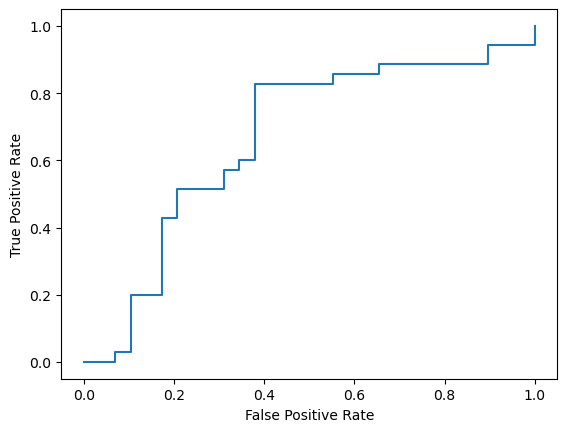

In [10]:
# plot roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# calculate the roc curve
fpr, tpr, thresholds = roc_curve(label_list, probability_list)

# plot the roc curve
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(label_list, prediction_list)

0.6960591133004925